# Brain Tumor Segmentation
#### *Author: Denis Mattarelli*

## Import necessary libraries

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

import random as rd

SEED = 2026

#### Set seed for reproducibility

In [ ]:
def set_seed(seed):
  rd.seed(seed)              # Random
  np.random.seed(seed)       # NumPy
  torch.manual_seed(seed)    # PyTorch
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

set_seed(SEED)

## Import Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lgg-mri-segmentation' dataset.
Path to dataset files: /kaggle/input/lgg-mri-segmentation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing


*   Train-Val-Test split: 60-20-20
*   Split at patient level to ensure fairness and increase robustness



In [ ]:
import os

basepath = os.path.join(path, "kaggle_3m")
patients = [p for p in os.listdir(basepath) if os.path.isdir(os.path.join(basepath, p))]
patients.sort() #for reproducibility of results

TOTAL_PATIENTS = len(patients)

In [ ]:
from sklearn.model_selection import train_test_split

train_folder, remaining = train_test_split(patients, train_size=0.6, random_state=SEED)

val_folder, test_folder = train_test_split(remaining, train_size=0.5, random_state=SEED)

print(f"Train Patients: {len(train_folder)} ({len(train_folder)/TOTAL_PATIENTS:.1%})")
print(f"Validation Patients: {len(val_folder)} ({len(val_folder)/TOTAL_PATIENTS:.1%})")
print(f"Test Patients: {len(test_folder)} ({len(test_folder)/TOTAL_PATIENTS:.1%})")

Train Patients: 66 (60.0%)
Validation Patients: 22 (20.0%)
Test Patients: 22 (20.0%)


In [ ]:
#ASSERT THE SAME SPLIT ACROSS DIFFERENT EXPERIMENTS AND ARCHITECTURES

previous_train_folders = set(['TCGA_HT_7680_19970202', 'TCGA_DU_8165_19970205', 'TCGA_HT_7684_19950816', 'TCGA_HT_7616_19940813', 'TCGA_HT_7884_19980913', 'TCGA_HT_8107_19980708', 'TCGA_FG_5964_20010511', 'TCGA_HT_7874_19950902', 'TCGA_CS_6668_20011025', 'TCGA_CS_6666_20011109', 'TCGA_HT_7608_19940304', 'TCGA_HT_A5RC_19990831', 'TCGA_CS_6665_20010817', 'TCGA_CS_6669_20020102', 'TCGA_HT_7602_19951103', 'TCGA_DU_5871_19941206', 'TCGA_DU_A5TU_19980312', 'TCGA_FG_8189_20030516', 'TCGA_DU_7306_19930512', 'TCGA_DU_7008_19830723', 'TCGA_HT_7694_19950404', 'TCGA_FG_A4MU_20030903', 'TCGA_DU_A5TR_19970726', 'TCGA_DU_6408_19860521', 'TCGA_DU_7014_19860618', 'TCGA_DU_8164_19970111', 'TCGA_DU_5874_19950510', 'TCGA_CS_6188_20010812', 'TCGA_DU_7019_19940908', 'TCGA_DU_7018_19911220', 'TCGA_CS_4944_20010208', 'TCGA_FG_6688_20020215', 'TCGA_DU_7299_19910417', 'TCGA_HT_7882_19970125', 'TCGA_FG_7637_20000922', 'TCGA_HT_7860_19960513', 'TCGA_HT_8113_19930809', 'TCGA_HT_7605_19950916', 'TCGA_DU_8162_19961029', 'TCGA_FG_A4MT_20020212', 'TCGA_DU_5851_19950428', 'TCGA_DU_A5TY_19970709', 'TCGA_FG_6692_20020606', 'TCGA_DU_6399_19830416', 'TCGA_DU_7294_19890104', 'TCGA_DU_8163_19961119', 'TCGA_DU_7010_19860307', 'TCGA_DU_5854_19951104', 'TCGA_HT_7877_19980917', 'TCGA_CS_5397_20010315', 'TCGA_DU_6401_19831001', 'TCGA_HT_8114_19981030', 'TCGA_DU_A5TP_19970614', 'TCGA_CS_4943_20000902', 'TCGA_HT_8111_19980330', 'TCGA_HT_7473_19970826', 'TCGA_FG_7634_20000128', 'TCGA_DU_8166_19970322', 'TCGA_DU_6404_19850629', 'TCGA_DU_6405_19851005', 'TCGA_HT_8563_19981209', 'TCGA_HT_7475_19970918', 'TCGA_DU_A5TS_19970726', 'TCGA_DU_6400_19830518', 'TCGA_CS_5396_20010302', 'TCGA_CS_4942_19970222'])
previous_val_folders = set(['TCGA_CS_6667_20011105', 'TCGA_HT_7856_19950831', 'TCGA_HT_A61B_19991127', 'TCGA_HT_A61A_20000127', 'TCGA_FG_6689_20020326', 'TCGA_CS_5395_19981004', 'TCGA_DU_7300_19910814', 'TCGA_DU_8168_19970503', 'TCGA_CS_6290_20000917', 'TCGA_EZ_7264_20010816', 'TCGA_DU_8167_19970402', 'TCGA_HT_8105_19980826', 'TCGA_DU_7298_19910324', 'TCGA_DU_A5TW_19980228', 'TCGA_HT_A616_19991226', 'TCGA_DU_7309_19960831', 'TCGA_DU_5872_19950223', 'TCGA_CS_4941_19960909', 'TCGA_FG_A60K_20040224', 'TCGA_HT_8106_19970727', 'TCGA_CS_5393_19990606', 'TCGA_FG_7643_20021104'])
print(previous_train_folders == set(train_folder))
print(previous_val_folders == set(val_folder))
print(train_folder)
print(val_folder)

True
True
['TCGA_HT_7680_19970202', 'TCGA_DU_8165_19970205', 'TCGA_HT_7684_19950816', 'TCGA_HT_7616_19940813', 'TCGA_HT_7884_19980913', 'TCGA_HT_8107_19980708', 'TCGA_FG_5964_20010511', 'TCGA_HT_7874_19950902', 'TCGA_CS_6668_20011025', 'TCGA_CS_6666_20011109', 'TCGA_HT_7608_19940304', 'TCGA_HT_A5RC_19990831', 'TCGA_CS_6665_20010817', 'TCGA_CS_6669_20020102', 'TCGA_HT_7602_19951103', 'TCGA_DU_5871_19941206', 'TCGA_DU_A5TU_19980312', 'TCGA_FG_8189_20030516', 'TCGA_DU_7306_19930512', 'TCGA_DU_7008_19830723', 'TCGA_HT_7694_19950404', 'TCGA_FG_A4MU_20030903', 'TCGA_DU_A5TR_19970726', 'TCGA_DU_6408_19860521', 'TCGA_DU_7014_19860618', 'TCGA_DU_8164_19970111', 'TCGA_DU_5874_19950510', 'TCGA_CS_6188_20010812', 'TCGA_DU_7019_19940908', 'TCGA_DU_7018_19911220', 'TCGA_CS_4944_20010208', 'TCGA_FG_6688_20020215', 'TCGA_DU_7299_19910417', 'TCGA_HT_7882_19970125', 'TCGA_FG_7637_20000922', 'TCGA_HT_7860_19960513', 'TCGA_HT_8113_19930809', 'TCGA_HT_7605_19950916', 'TCGA_DU_8162_19961029', 'TCGA_FG_A4MT_

#### Organize directories for Train/Val/Test split

In [ ]:
import shutil

dataset_dir = "/content/dataset"
os.makedirs(dataset_dir, exist_ok=True)

# --- Setup Output Directories ---
splits = {
    'train': train_folder,
    'val': val_folder,
    'test': test_folder
}

for split_name in splits.keys():
    os.makedirs(os.path.join(dataset_dir, split_name), exist_ok=True)

# --- Move/Copy Folders ---
for split_name, patient_list in splits.items():
    dest_dir = os.path.join(dataset_dir, split_name)

    for patient_folder_name in patient_list:
        src_path = os.path.join(basepath, patient_folder_name)
        dest_path = os.path.join(dest_dir, patient_folder_name)

        # Use shutil.copytree for copying the entire directory, including all MRI slices.
        shutil.copytree(src_path, dest_path)

print("\nPatient-Level Splitting Complete!")


Patient-Level Splitting Complete!


In [ ]:
#Split the folders in img_folders and mask_folders (labels)

for split_name, patient_list in splits.items():
  temp_base_path = os.path.join(dataset_dir, split_name)

  for patient in patient_list:
    img_dest_dir = os.path.join(temp_base_path, patient, "images")
    mask_dest_dir = os.path.join(temp_base_path, patient, "mask")
    os.makedirs(img_dest_dir, exist_ok=True)
    os.makedirs(mask_dest_dir, exist_ok=True)

    files = [f for f in os.listdir(os.path.join(temp_base_path, patient)) if not os.path.isdir(os.path.join(temp_base_path, patient, f))]

    for f in files:
      src_path = os.path.join(temp_base_path, patient, f)
      if "_mask" in f:
        dst_path = os.path.join(mask_dest_dir, f)
      else:
        dst_path = os.path.join(img_dest_dir, f)

      shutil.copy2(src_path, dst_path)

print("✅ Files successfully sorted into 'images/' and 'masks/' folders.")

✅ Files successfully sorted into 'images/' and 'masks/' folders.


In [ ]:
import re

def extract_slice_id(filename):
    name = os.path.splitext(filename)[0]      # remove .tif
    if name.endswith("_mask"):
        name = name[:-5]                      # remove _mask
    m = re.search(r"(\d+)$", name)            # trailing digits
    return int(m.group(1)) if m else None

## Data Augmentation

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1. Define the augmentation pipeline
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        rotate=(-15, 15),
        scale=(0.9, 1.1),
        shear=(-10, 10),
        p=0.7,
        interpolation=1,      # 1 = cv2.INTER_LINEAR (for image)
        mask_interpolation=0  # 0 = cv2.INTER_NEAREST (for mask)
    ),
    A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),

    # Pixel-level transforms are applied ONLY to the image by default
    #A.ColorJitter(brightness=0.3, contrast=0.3, p=0.5),
    #A.GaussianBlur(blur_limit=(3, 7), p=0.3),

    ToTensorV2() # Converts numpy image/mask to PyTorch tensors
], seed=SEED)

/tmp/ipython-input-281538261.py:15: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),


## Dataset class creation

In [ ]:
class MRISegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: path to train/val/test directory containing patient folders
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Loop through each patient folder
        for patient_name in sorted(os.listdir(root_dir)):
            patient_path = os.path.join(root_dir, patient_name)
            images_dir = os.path.join(patient_path, "images")
            masks_dir  = os.path.join(patient_path, "mask")

            if not os.path.isdir(images_dir) or not os.path.isdir(masks_dir):
              print(f"WARNING: {images_dir} or {masks_dir} is not a folder")
              continue  # skip malformed folders

            # sort both lists to maintain correspondence
            image_files = os.listdir(images_dir)
            mask_files = os.listdir(masks_dir)

            image_files.sort(key=lambda f: extract_slice_id(f))
            mask_files.sort(key=lambda f: extract_slice_id(f))

            # Ensure equal number of slices
            assert len(image_files) == len(mask_files), f"Mismatch in {patient_name}"

            # Pair each image with its matching mask
            for img_name, mask_name in zip(image_files, mask_files):
                # Optional: verify name correspondence (e.g. same slice number)
                if os.path.splitext(img_name)[0] not in mask_name:
                    print(f"Warning: potential mismatch {img_name} <-> {mask_name}")

                img_path = os.path.join(images_dir, img_name)
                mask_path = os.path.join(masks_dir, mask_name)
                self.samples.append((img_path, mask_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path = self.samples[idx]

        # Load
        image = np.array(Image.open(image_path), dtype=np.float32)
        mask  = np.array(Image.open(mask_path), dtype=np.float32)

        # Normalize per image
        image = (image - image.min(axis=(0,1), keepdims=True)) / (image.max(axis=(0,1), keepdims=True) - image.min(axis=(0,1), keepdims=True) + 1e-8)

        #Binarize the mask
        mask = (mask > 0.5).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  #(C, H, W) tensor
            mask = augmented['mask']    #(H, W) tensor
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1))  # (3,H,W)
            mask  = torch.from_numpy(mask)

        mask = mask.unsqueeze(0)  # Add 1 dimension for U-Net input (1,H,W)

        return image, mask

In [ ]:
train_dataset = MRISegmentationDataset(root_dir=os.path.join(dataset_dir, "train"), transform=train_transform)
val_dataset = MRISegmentationDataset(root_dir=os.path.join(dataset_dir, "val"))
test_dataset = MRISegmentationDataset(root_dir=os.path.join(dataset_dir, "test"))

## Visualize an example

Augmented image shape: torch.Size([3, 256, 256])
Augmented mask shape: torch.Size([1, 256, 256])
Unique values in augmented mask: tensor([0., 1.])


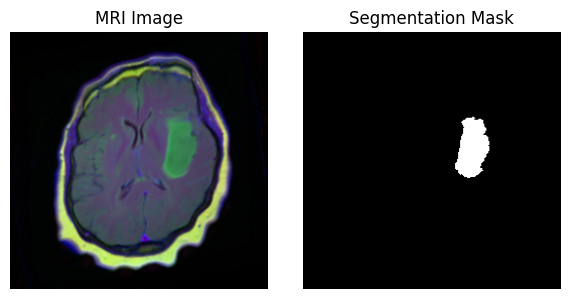

In [ ]:
to_pil = transforms.ToPILImage()

img, mask = train_dataset.__getitem__(10) #The pair (image, mask) is the same but whenever we call __getitem__ a random transformation is applied
print(f"Augmented image shape: {img.shape}")
print(f"Augmented mask shape: {mask.shape}")
print(f"Unique values in augmented mask: {torch.unique(mask)}")

img = to_pil(img)
mask = to_pil(mask)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # 1 row, 2 columns

axes[0].imshow(img, cmap='gray')   # or cmap=None if it's RGB
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Segmentation Mask")
axes[1].axis("off")

np_img = np.array(img)
print(np_img.shape)

plt.tight_layout()
plt.show()

## Support Class

*   ConvBlockPlus: convolution block with Batch Normalization and Dropout



In [ ]:
class ConvBlockPlus(nn.Module):

    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv_block(x)

## Architecture



In [ ]:
class UNetPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        #Encoder
        self.x00 = ConvBlockPlus(in_channels, 32)
        self.x10 = ConvBlockPlus(32, 64)
        self.x20 = ConvBlockPlus(64, 128)
        self.x30 = ConvBlockPlus(128, 256)
        self.x40 = ConvBlockPlus(256, 512)

        #Horizontal connections
        #Uppermost Layer (horizontal)
        self.x01 = ConvBlockPlus(32*2, 32)
        self.x02 = ConvBlockPlus(32*3, 32)
        self.x03 = ConvBlockPlus(32*4, 32)
        self.x04 = ConvBlockPlus(32*5, 32)

        #2nd layer
        self.x11 = ConvBlockPlus(64*2, 64)
        self.x12 = ConvBlockPlus(64*3, 64)
        self.x13 = ConvBlockPlus(64*4, 64)

        #3rd layer
        self.x21 = ConvBlockPlus(128*2, 128)
        self.x22 = ConvBlockPlus(128*3, 128)

        #4th layer
        self.x31 = ConvBlockPlus(256*2, 256)

        #UpConvolutions
        self.upx10 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.upx11 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.upx12 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.upx13 = nn.ConvTranspose2d(64, 32, 2, stride=2)

        self.upx20 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.upx21 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.upx22 = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.upx30 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.upx31 = nn.ConvTranspose2d(256, 128, 2, stride=2)

        self.upx40 = nn.ConvTranspose2d(512, 256, 2, stride=2)

        self.out1_conv = nn.Conv2d(32, out_channels, 1)
        self.out2_conv = nn.Conv2d(32, out_channels, 1)
        self.out3_conv = nn.Conv2d(32, out_channels, 1)
        self.out4_conv = nn.Conv2d(32, out_channels, 1)

    def forward(self, x, mode='L4'):
      #Encoder
        x00 = self.x00(x)
        x10 = self.x10(F.max_pool2d(x00, 2))
        x01 = self.x01(torch.cat([x00, self.upx10(x10)], dim=1))
        out1 = torch.sigmoid(self.out1_conv(x01))

        if not(self.training) and (mode == 'L1'):
          return out1

        x20 = self.x20(F.max_pool2d(x10, 2))
        x11 = self.x11(torch.cat([x10, self.upx20(x20)], dim=1))
        x02 = self.x02(torch.cat([x00, x01, self.upx11(x11)], dim=1))
        out2 = torch.sigmoid(self.out2_conv(x02))

        if not(self.training) and (mode == 'L2'):
          return out2

        x30 = self.x30(F.max_pool2d(x20, 2))
        x21 = self.x21(torch.cat([x20, self.upx30(x30)], dim=1))
        x12 = self.x12(torch.cat([x10, x11, self.upx21(x21)], dim=1))
        x03 = self.x03(torch.cat([x00, x01, x02, self.upx12(x12)], dim=1))
        out3 = torch.sigmoid(self.out3_conv(x03))

        if not(self.training) and (mode == 'L3'):
          return out3

        x40 = self.x40(F.max_pool2d(x30, 2))
        x31 = self.x31(torch.cat([x30, self.upx40(x40)], dim=1))
        x22 = self.x22(torch.cat([x20, x21, self.upx31(x31)], dim=1))
        x13 = self.x13(torch.cat([x10, x11, x12, self.upx22(x22)], dim=1))
        x04 = self.x04(torch.cat([x00, x01, x02, x03, self.upx13(x13)], dim=1))
        out4 = torch.sigmoid(self.out4_conv(x04))

        if self.training:
          return out1, out2, out3, out4

#-------- MODEL IN EVALUATION MODE---------------#

        if (mode == 'accurate'):
          outputs = torch.stack([out1, out2, out3, out4], dim=0)
          return torch.mean(outputs, dim=0)

        return out4 #mode == 'L4'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetPlus().to(device)
model

## Loss Functions


*   Dice Loss: 1 - Dice Score (maximize the Dice (IoU) score)
*   Twerski Loss: Dice Loss but can penalyze the model for wrong FP or FN predictions
*   Binary Cross Entropy: pixel-wise loss
*   Combined Loss: 0.5 * BCE + 0.5 * Twerski (combine pixel-wise with region-wise loss to maximize performances)



In [ ]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        """
        Initializes the TverskyLoss module.

        Args:
            alpha (float): Controls the penalty for false positives (FP).
                           Default: 0.5
            beta (float): Controls the penalty for false negatives (FN).
                          Default: 0.5 (which makes it equivalent to Dice loss)
            smooth (float): A small value added to the numerator and denominator
                            to prevent division by zero.

        Example:
            To penalize False Negatives more (e.g., for medical tasks):
            loss_fn = TverskyLoss(alpha=0.3, beta=0.7)

            To penalize False Positives more:
            loss_fn = TverskyLoss(alpha=0.7, beta=0.3)
        """
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        """
        Calculates the Tversky loss.

        Args:
            inputs (torch.Tensor): The model's predictions. These should be
                                   probabilities in the range [0, 1].
                                   For binary segmentation, this is typically
                                   the output of a sigmoid function.
                                   Shape: [batch_size, ...]
            targets (torch.Tensor): The ground truth labels (0 or 1).
                                    Shape: [batch_size, ...]
        """

        # Ensure inputs and targets are contiguous
        inputs = inputs.contiguous()
        targets = targets.contiguous()

        TP = (inputs * targets).sum(dim=(2,3))
        FP = (inputs * (1 - targets)).sum(dim=(2,3))
        FN = ((1 - inputs) * targets).sum(dim=(2,3))

        # Calculate the Tversky Index
        tversky_index = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)

        return 1 - tversky_index.mean()

In [ ]:
def dice_loss(pred, target, eps=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3)) #sum over height and width
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) #sum over height and width
    dice = (2. * intersection + eps) / (union + eps)
    return 1 - dice.mean()

def combined_loss(pred, target, criterion):
    twerski = TverskyLoss(alpha=0.5, beta=0.5)
    return 0.5 * criterion(pred, target) + 0.5 * twerski(pred, target)

## Early Stopping Class

#### Prevent overfitting by stopping after *patience* epochs of not improving

In [ ]:
#EARLY STOP CLASS
PATH = '/content/drive/MyDrive/Projects/Brain Tumor Segmentation/U-Net/Dice2026.pt'

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=1e-3, path=PATH, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): function to use for printing messages.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, epoch, model, optimizer, train_loss_list, val_loss_list):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, epoch, model, optimizer, train_loss_list, val_loss_list)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, epoch, model, optimizer, train_loss_list, val_loss_list)
            self.counter = 0

    def save_checkpoint(self, val_loss, epoch, model, optimizer, train_loss_list, val_loss_list):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss_list,
            'val_loss': val_loss_list
        }, self.path)
        self.val_loss_min = val_loss

## Training Loop





In [ ]:
# Create loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
initial_lr = 1e-4
criterion = nn.BCELoss()  # Binary Cross Entropy (for binary masks)
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)

In [ ]:
#STANDARD TRAINING

n_epochs = 50
train_loss_list = []
val_loss_list = []
patience = 5
earlystop = EarlyStopping(patience=patience, verbose=True)

for epoch in tqdm(range(n_epochs)):
  #TRAINING STAGE
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        out1, out2, out3, out4 = model(imgs)
        loss1 = combined_loss(out1, masks, criterion)
        loss2 = combined_loss(out2, masks, criterion)
        loss3 = combined_loss(out3, masks, criterion)
        loss4 = combined_loss(out4, masks, criterion)
        loss = (loss1 + loss2 + loss3 + loss4) / 4
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

#VALIDATION STAGE
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs, mode='accurate')
            loss = combined_loss(outputs, masks, criterion)
            val_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    earlystop(train_loss, val_loss, epoch, model, optimizer, train_loss_list, val_loss_list)

    if earlystop.early_stop:
      print("Early Stopping!")
      break

    train_loss_list.append(round(train_loss, 4))
    val_loss_list.append(round(val_loss, 4))

    print(f"Epoch [{epoch+1}/{n_epochs}]  Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")

### Plot Training vs Validation Loss

In [ ]:
# --- 2. Matplotlib Plotting Code ---
plt.figure(figsize=(10, 6)) # Create a new figure with a specified size

# Plot the training loss
plt.plot(range(1, n_epochs+1), train_loss_list, label='Training Loss', marker='o', linestyle='-', color='blue')

# Plot the validation loss
plt.plot(range(1, n_epochs+1), val_loss_list, label='Validation Loss', marker='x', linestyle='--', color='red')

# Add a title and labels
#plt.title('Attention U-Net Training Loss vs. Validation Loss')
plt.title('Attention U-Net Unbalanced loss combination')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

# Add a legend to distinguish the two lines
plt.legend()

# Add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()

## Test Loop to collect predictions

In [ ]:
test_loss = 0.0
all_imgs = []
all_preds = []
all_gts = [] #ground truths

model.eval()

with torch.no_grad():
  for imgs, masks in tqdm(test_loader):
    imgs, masks = imgs.to(device), masks.to(device)

    outputs = model(imgs, mode='L4')

    loss = combined_loss(outputs, masks, criterion)
    test_loss += loss.item()

    all_imgs.append(imgs.cpu())
    all_preds.append(outputs.cpu())
    all_gts.append(masks.cpu())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

  0%|          | 0/52 [00:00<?, ?it/s]

Test Loss: 0.0000


In [ ]:
preds = torch.cat(all_preds) #concat all preds
gts   = torch.cat(all_gts)
imgs = torch.cat(all_imgs)

binary_preds = (preds > 0.5).float() #convert to binary masks

## Results



In [ ]:
def compute_scores(pred, target, eps=1e-6):
    inter = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (inter + eps)/(union + eps), (2 * inter + eps) / (union + eps)

In [ ]:
accuracy = (binary_preds == gts).float().mean().item()
iou, dice = compute_scores(binary_preds, gts)

print("Dice coefficient score: ", dice)
print("IoU: ", iou)
print("Accuracy: ", accuracy)

#### Convert Images back to PIL format to visualize

In [ ]:
imgs = [to_pil(img) for img in imgs]
gts = [to_pil(gt) for gt in gts]
preds_to_plot = [to_pil(pred) for pred in binary_preds]

In [ ]:
interval = len(imgs)

idx = rd.randint(0, interval-1)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(imgs[idx], cmap=None)
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(gts[idx], cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis("off")

axes[2].imshow(preds_to_plot[idx], cmap='gray')
axes[2].set_title("Prediction")
axes[2].axis("off")

plt.tight_layout()
plt.show()